<a href="https://colab.research.google.com/github/Kira1108/GraphNN/blob/main/Semi_Supervised_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install spektral

In [3]:
import numpy as np
import tensorflow as tf
import spektral

Change Node Attributes (Not Graph Structure)

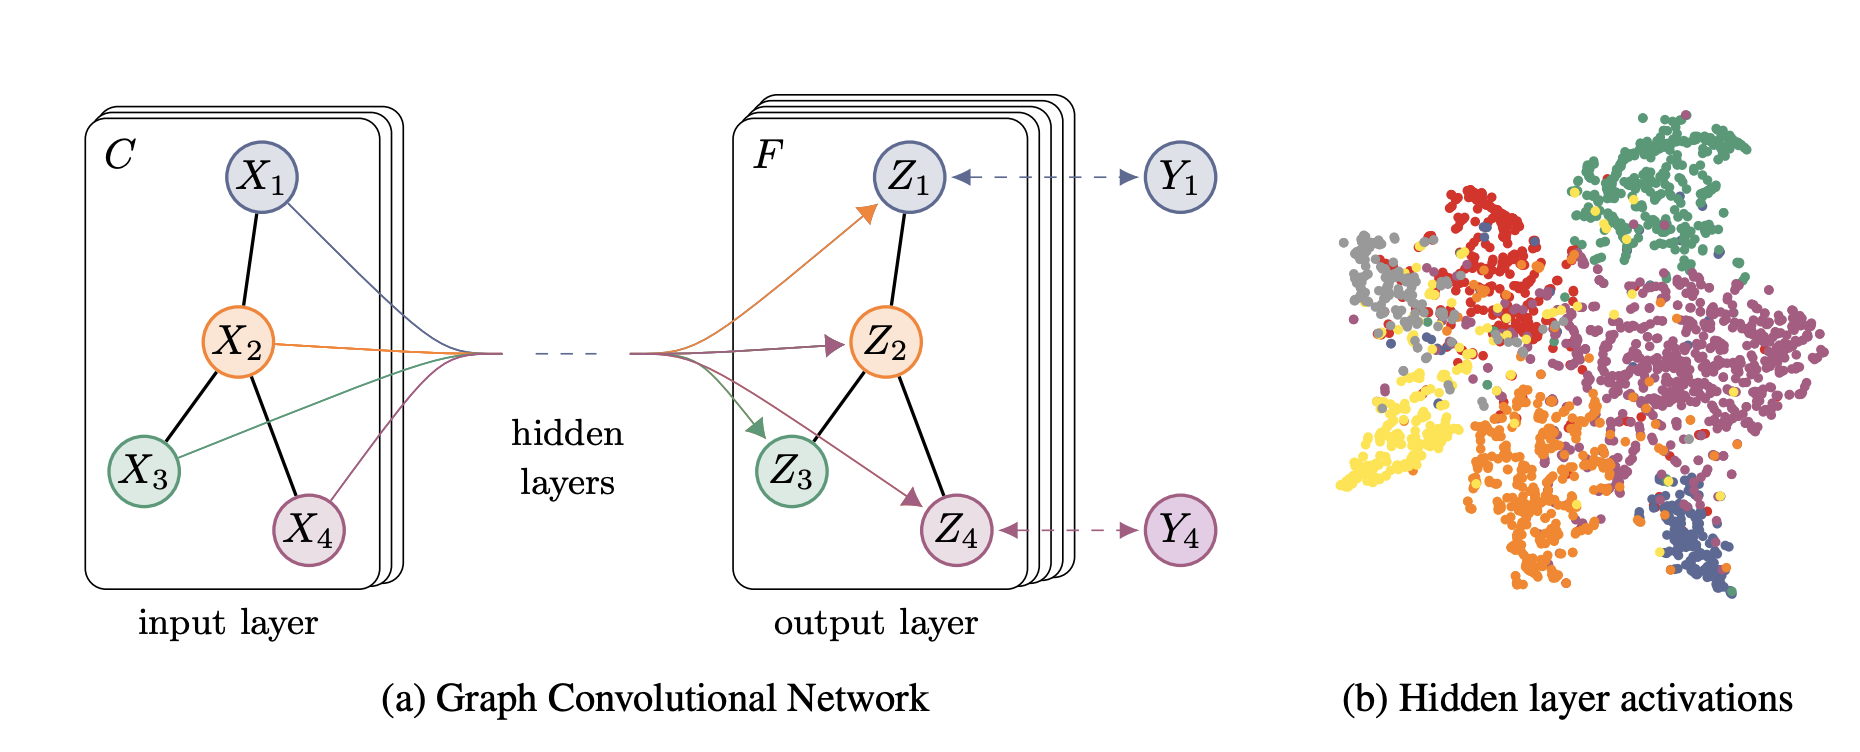

In [26]:
data = spektral.datasets.citation.Citation('cora', random_split=False, normalize_x=False)
train_mask, test_mask, val_mask = data.mask_tr, data.mask_te, data.mask_va
features = data.graphs[0].x
labels = data.graphs[0].y
adj = data.graphs[0].a
adj = adj.todense() + np.eye(adj.shape[0])
adj = adj.astype(np.float32)
features = features.astype(np.float32)

print("Feature shape: ",features.shape)
print("Adjacent matrix shape: ", adj.shape)
print("Label shape :", labels.shape)
print("Train masked: ", np.sum(train_mask))
print("Validation masked: ", np.sum(val_mask))
print("Test masked: ", np.sum(test_mask))


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Feature shape:  (2708, 1433)
Adjacent matrix shape:  (2708, 2708)
Label shape : (2708, 7)
Train masked:  140
Validation masked:  500
Test masked:  1000


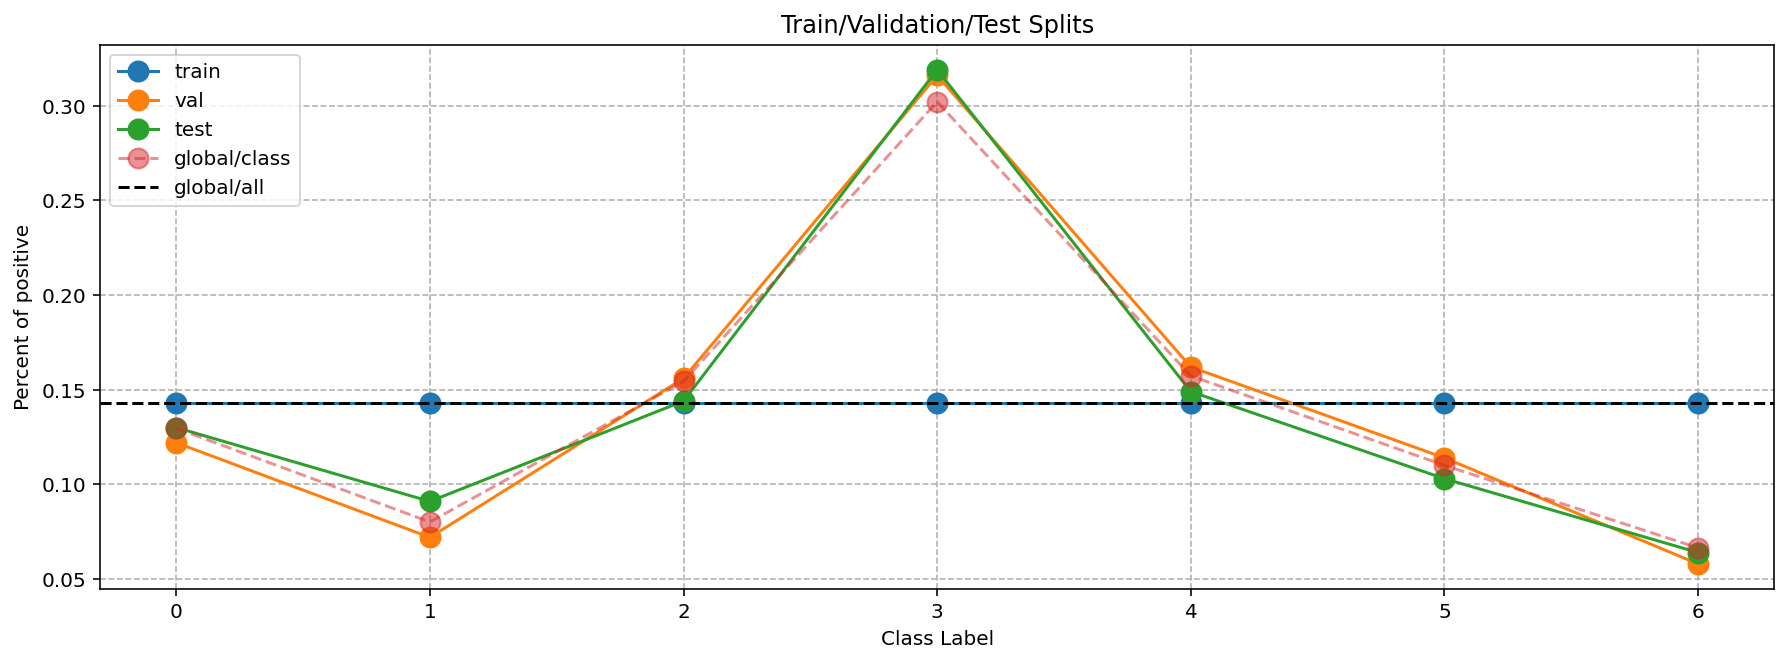

In [89]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize = (15,5))
plt.plot(np.arange(7), labels[train_mask].mean(axis = 0), label = 'train', marker = '.', markersize = 20)
plt.plot(np.arange(7), labels[val_mask].mean(axis = 0), label = 'val', marker = '.', markersize = 20)
plt.plot(np.arange(7), labels[test_mask].mean(axis = 0), label = 'test', marker = '.', markersize = 20)
plt.plot(np.arange(7), labels.mean(axis = 0), label = 'global/class', marker = '.', markersize = 20, linestyle = '--', alpha = 0.5)
plt.axhline(labels.mean(), label = "global/all", linestyle = '--', color = 'k')
plt.grid(linestyle = '--')
plt.legend(loc = 'upper left')
plt.xlabel("Class Label")
plt.ylabel("Percent of positive")
plt.title("Train/Validation/Test Splits")
plt.show()

In [78]:
class GNNBlock(tf.keras.layers.Layer):
    """A GNN blcok transform a graph into another graph without changing adjacency matrix
        Only node feature changes
    """
    def __init__(self, units, act):
        super().__init__()
        self.transform = tf.keras.layers.Dense(units)
        self.act = act

    def call(self, x, adj):
        # a dense layer(weights) applied to each node
        x_trans = self.transform(x)

        # averaging over neighbors
        h_prime = tf.matmul(adj, x_trans)
        return self.act(h_prime)


class GNN(tf.keras.models.Model):
    """A GNN has many GNN Blocks,the last layer represent output node features"""
    def __init__(self, units, K = 7):
        super().__init__()

        self.gnn_layer1 = GNNBlock(units, tf.nn.relu)
        self.gnn_layer2 = GNNBlock(K, tf.identity)

    def call(self, x, adj):
        # hidden graph
        hidden = self.gnn_layer1(x, adj)

        # output graph
        out = self.gnn_layer2(hidden, adj)
        return out

def masked_softmax_cross_entropy(logits, labels, mask):
    # classification loss
    loss = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)

    # compute weigth of each sample
    mask = tf.cast(mask, dtype = tf.float32)
    mask /= tf.reduce_mean(mask)

    # weighted loss over all masked samples
    loss *= mask

    # avg, weighted loss over all masked samples
    return tf.reduce_mean(loss)


def masked_accuracy(logits, labels, mask):
    # compute accuracy over all samples
    correct_predict = tf.equal(
        tf.argmax(logits, 1), 
        tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_predict,tf.float32)

    # compute weight of all samples
    mask = tf.cast(mask, dtype = tf.float32)
    mask /= tf.reduce_mean(mask)

    # currectness of all samples(nodes that masked)
    accuracy_all  *= mask
    return tf.reduce_mean(accuracy_all)

In [80]:
def train_gnn(
    model, 
    features, 
    adj, 
    labels, 
    train_mask, 
    val_mask, 
    test_mask,  
    epochs = 20, 
    optimizer = None, 
    lr = 0.001):

    if not optimizer:
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

    best_accuracy = 0.0

    for epoch in range(epochs + 1):
        with tf.GradientTape() as tape:
            logits = model(features, adj)
            loss = masked_softmax_cross_entropy(logits, labels, train_mask)

        variables = tape.watched_variables()
        grads = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(grads, variables))    

        logits = model(features, adj)
        val_acc = masked_accuracy(logits, labels, val_mask)
        test_acc = masked_accuracy(logits, labels, test_mask)

        if val_acc > best_accuracy:
            best_accuracy = val_acc


        print(f"Epoch: {epoch} || Train Loss: {loss.numpy()} || Val Acc: {val_acc.numpy()} || Test Acc: {test_acc.numpy()}")

需要的所有信息： 
1. 节点信息(preprocess 过后的用户信息)
2. 连接信息(战斗或者资源或者社交的邻接矩阵)
3. labels(通过时间窗口构建的future labels)
4. mask (train_mask: equal positive ratio on all class, test_mask = val_mask = global positive ration)    


上面的信息都不重要，都简单：
重要的是：
这个图怎么构建才能合理，多久的时间窗口，才能构建出一个有代表性的图。

In [82]:
model = GNN(units=128, K=7)
train_gnn(model, features, adj, labels, train_mask, val_mask, test_mask)

Epoch: 0 || Train Loss: 5.669920921325684 || Val Acc: 0.19599999487400055 || Test Acc: 0.20499999821186066
Epoch: 1 || Train Loss: 2.8492534160614014 || Val Acc: 0.2879999876022339 || Test Acc: 0.29999998211860657
Epoch: 2 || Train Loss: 2.3573014736175537 || Val Acc: 0.34200000762939453 || Test Acc: 0.3569999933242798
Epoch: 3 || Train Loss: 1.7615044116973877 || Val Acc: 0.39399996399879456 || Test Acc: 0.41899994015693665
Epoch: 4 || Train Loss: 1.2486276626586914 || Val Acc: 0.4259999692440033 || Test Acc: 0.46799999475479126
Epoch: 5 || Train Loss: 0.9249014854431152 || Val Acc: 0.48399996757507324 || Test Acc: 0.5270000100135803
Epoch: 6 || Train Loss: 0.718096911907196 || Val Acc: 0.5299999713897705 || Test Acc: 0.5689999461174011
Epoch: 7 || Train Loss: 0.5787588357925415 || Val Acc: 0.5699999928474426 || Test Acc: 0.6200000047683716
Epoch: 8 || Train Loss: 0.47372692823410034 || Val Acc: 0.5979999899864197 || Test Acc: 0.6579999923706055
Epoch: 9 || Train Loss: 0.3972876071929

In [83]:
model = GNN(units=64, K=7)
train_gnn(model, features, adj, labels, train_mask, val_mask, test_mask)

Epoch: 0 || Train Loss: 5.4399542808532715 || Val Acc: 0.1599999964237213 || Test Acc: 0.15999998152256012
Epoch: 1 || Train Loss: 2.8225626945495605 || Val Acc: 0.32600000500679016 || Test Acc: 0.33400002121925354
Epoch: 2 || Train Loss: 1.7041927576065063 || Val Acc: 0.387999951839447 || Test Acc: 0.3969999849796295
Epoch: 3 || Train Loss: 1.4161179065704346 || Val Acc: 0.4339999854564667 || Test Acc: 0.4350000023841858
Epoch: 4 || Train Loss: 1.1609665155410767 || Val Acc: 0.4859999716281891 || Test Acc: 0.5020000338554382
Epoch: 5 || Train Loss: 0.8905826210975647 || Val Acc: 0.5579999685287476 || Test Acc: 0.5710000395774841
Epoch: 6 || Train Loss: 0.692982017993927 || Val Acc: 0.5899999737739563 || Test Acc: 0.6079999804496765
Epoch: 7 || Train Loss: 0.593504786491394 || Val Acc: 0.6240000128746033 || Test Acc: 0.6439999938011169
Epoch: 8 || Train Loss: 0.5466383695602417 || Val Acc: 0.6459999680519104 || Test Acc: 0.6660000085830688
Epoch: 9 || Train Loss: 0.4720727503299713 || 

In [93]:
model = GNN(units=64, K=7)
train_gnn(model, features, tf.eye(adj.shape[0]), labels, train_mask, val_mask, test_mask, epochs = 50)

Epoch: 0 || Train Loss: 1.9626942873001099 || Val Acc: 0.18800000846385956 || Test Acc: 0.18799999356269836
Epoch: 1 || Train Loss: 1.9097750186920166 || Val Acc: 0.2019999921321869 || Test Acc: 0.20499999821186066
Epoch: 2 || Train Loss: 1.8592616319656372 || Val Acc: 0.21599999070167542 || Test Acc: 0.22299998998641968
Epoch: 3 || Train Loss: 1.810604214668274 || Val Acc: 0.22999998927116394 || Test Acc: 0.2409999668598175
Epoch: 4 || Train Loss: 1.763492226600647 || Val Acc: 0.25200000405311584 || Test Acc: 0.2589999735355377
Epoch: 5 || Train Loss: 1.7173657417297363 || Val Acc: 0.27399998903274536 || Test Acc: 0.2789999842643738
Epoch: 6 || Train Loss: 1.6719361543655396 || Val Acc: 0.2839999794960022 || Test Acc: 0.296999990940094
Epoch: 7 || Train Loss: 1.627245545387268 || Val Acc: 0.30799999833106995 || Test Acc: 0.31700000166893005
Epoch: 8 || Train Loss: 1.5832853317260742 || Val Acc: 0.3240000009536743 || Test Acc: 0.3359999656677246
Epoch: 9 || Train Loss: 1.53956413269042

In [99]:
adj_telda = adj / adj.sum(axis = -1)

model = GNN(units=64, K=7)
train_gnn(model, features, adj_telda, labels, train_mask, val_mask, test_mask, epochs = 50)

Epoch: 0 || Train Loss: 1.949465036392212 || Val Acc: 0.08399999141693115 || Test Acc: 0.07999999076128006
Epoch: 1 || Train Loss: 1.9172757863998413 || Val Acc: 0.1119999960064888 || Test Acc: 0.13599999248981476
Epoch: 2 || Train Loss: 1.8858928680419922 || Val Acc: 0.17799998819828033 || Test Acc: 0.20999999344348907
Epoch: 3 || Train Loss: 1.8547320365905762 || Val Acc: 0.25199997425079346 || Test Acc: 0.28700000047683716
Epoch: 4 || Train Loss: 1.82321298122406 || Val Acc: 0.34599998593330383 || Test Acc: 0.37599998712539673
Epoch: 5 || Train Loss: 1.7911641597747803 || Val Acc: 0.4140000343322754 || Test Acc: 0.4439999759197235
Epoch: 6 || Train Loss: 1.7579855918884277 || Val Acc: 0.4959999918937683 || Test Acc: 0.4909999668598175
Epoch: 7 || Train Loss: 1.7234601974487305 || Val Acc: 0.5360000133514404 || Test Acc: 0.5209999680519104
Epoch: 8 || Train Loss: 1.6876590251922607 || Val Acc: 0.5680000185966492 || Test Acc: 0.5489999651908875
Epoch: 9 || Train Loss: 1.65082156658172

In [119]:
deg_mat = tf.reduce_sum(adj, axis = -1)
norm_deg = tf.linalg.diag(1.0/tf.sqrt(deg_mat))
adj_telda = tf.matmul(norm_deg, tf.matmul(adj, norm_deg))

model = GNN(units=64, K=7)
train_gnn(model, features, adj_telda, labels, train_mask, val_mask, test_mask, epochs = 50)

Epoch: 0 || Train Loss: 1.945801019668579 || Val Acc: 0.14399999380111694 || Test Acc: 0.12699998915195465
Epoch: 1 || Train Loss: 1.912693977355957 || Val Acc: 0.17799998819828033 || Test Acc: 0.15700000524520874
Epoch: 2 || Train Loss: 1.8809106349945068 || Val Acc: 0.25 || Test Acc: 0.23199999332427979
Epoch: 3 || Train Loss: 1.8499600887298584 || Val Acc: 0.31200000643730164 || Test Acc: 0.3460000157356262
Epoch: 4 || Train Loss: 1.819157600402832 || Val Acc: 0.39799997210502625 || Test Acc: 0.4219999611377716
Epoch: 5 || Train Loss: 1.788004994392395 || Val Acc: 0.4859999716281891 || Test Acc: 0.5139999389648438
Epoch: 6 || Train Loss: 1.7561696767807007 || Val Acc: 0.543999969959259 || Test Acc: 0.5819999575614929
Epoch: 7 || Train Loss: 1.723307490348816 || Val Acc: 0.593999981880188 || Test Acc: 0.6320000290870667
Epoch: 8 || Train Loss: 1.6893031597137451 || Val Acc: 0.621999979019165 || Test Acc: 0.6659999489784241
Epoch: 9 || Train Loss: 1.6542330980300903 || Val Acc: 0.6380